In [1]:
import pandas as pd
import seaborn as sns
from functools import partial
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv('data/processed/heart_risk.csv')
irrelevant = ['id']
df = df.drop(irrelevant, axis=1)

We'll start by handling some of the missing values in the dataset. The following cell shows the missing value proportion for each column.

In [8]:
df.isna().mean().sort_values()

age                      0.000000
sex                      0.000000
source                   0.000000
cad                      0.000000
cp_type                  0.000000
rest_ecg                 0.002225
angiogram_date           0.014461
chol                     0.033370
ekg_date                 0.060067
ex_angina                0.061179
heart_rate_peak          0.061179
heart_rate_rest          0.062291
ex_duration              0.062291
ex_hypotension           0.064516
blood_press_d_rest       0.065628
blood_press_s_rest       0.065628
st_dep                   0.068966
blood_press_s_peak       0.070078
ccblocker                0.070078
blood_press_d_peak       0.070078
nitrate                  0.072303
betablocker              0.073415
digitalis                0.075640
diuretic                 0.091212
fasting_blood_sugar      0.100111
met                      0.116796
ex_protocol              0.124583
rldv5e                   0.157953
cp_loc                   0.313682
cp_exertion   

First, let's focus on the columns where at least 50% of the values are missing. That's not a number backed by any theory, we just need somewhere to start. Let's look at each column in this set from the one with the most to the one with the least missing values.
- pncaden is supposedly a summary of chest pain variables, but since all of its values are missing, there's not much we can do other than dropping it
- ejection_frac_ex, wm_abnormal_ex, wm_abnormal_rest and ejection_frac_rest all relate to ejection fraction measurements and heart wall abnormalities. These seem like they could be strongly correlated to CAD, but they're all ranging from 96% to 99% missing, so we're gonna drop these also.
- Even though diabetes is a known predictor of heart disease, the amount of missing values in this dataset makes it really hard for us to draw any conclusions about it. We'll keep an eye on other possible indicators of diabetes, like fasting blood sugar, but for now, at 87% missing, this is not suitable for our analysis. Let's drop that one as well.
- smoking is commonly associated with a high risk of heart disease, and even though the smoker column's values are missing in 74% of the rows, there are other proxies available (like smoker_cigs_per_day and smoker_years) that can help us determine some of the missing values.
- vessels_colored is a numeric direct measurement from a medical test, which is certainly valuable for our analysis. We'll keep this column for now and look at ways to deal with the missing values.
- thalium_stress_result is one of the main test results gathered, so we'll keep it for now and try to impute values where possible.
- st_dep_measured_at may not provide valuable data, but we'll check it for correlation and see if we can use it in any way.

From these observations, we can start by dropping all columns with 75% missing values or more.

In [9]:
df = df.drop(df.isna().mean()[df.isna().mean() >= .75].index, axis=1)

In [10]:
def infer_smoking(row):
    if row.smoker == 'yes' or row.smoker_cigs_per_day > 0 or row.smoker_years > 0:
        out = 'yes'
    else:
        out = row.smoker
    return out

before_nan_mean = df.smoker.isna().mean()
before_nan_count = df.smoker.isna().sum()
df.smoker = df.apply(infer_smoking, axis=1)
after_nan_mean = df.smoker.isna().mean()
after_nan_count = df.smoker.isna().sum()
print("Smoker had {} ({:.2f}%) new values inferred from other columns".format(before_nan_count - after_nan_count, (before_nan_mean - after_nan_mean)*100))

Smoker had 167 (18.58%) new values inferred from other columns


We got almost 20% extra values for the smoker column by inferring missing values!

There's a "catch" in the data found earlier during EDA. Let's investigate the rldv5 and rldv5e columns

cleveland_minus_corrupted has 0 valid entries for rldv5. mean value is nan 

hungarian has 293 valid entries for rldv5. mean value is 13.68259385665529 

long-beach-va has 135 valid entries for rldv5. mean value is 16.007407407407406 

switzerland has 46 valid entries for rldv5. mean value is 14.23913043478261 

cleveland_minus_corrupted has 282 valid entries for rldv5e. mean value is 123.58510638297872 

hungarian has 294 valid entries for rldv5e. mean value is 13.295918367346939 

long-beach-va has 135 valid entries for rldv5e. mean value is 15.792592592592593 

switzerland has 46 valid entries for rldv5e. mean value is 14.73913043478261 

C:\Users\guischmitd\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\guischmitd\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = re

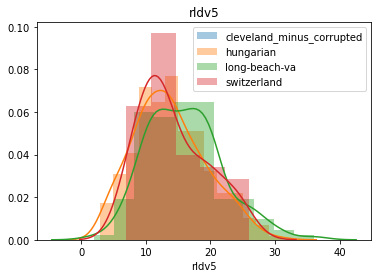

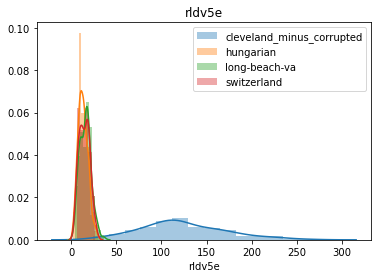

In [11]:
def plot_hist(df_, col):
    print(df_.source.unique()[0], 'has', len(df_[col].dropna()), f'valid entries for {col}. mean value is', df_[col].mean(), '\n')
    sns.distplot(df_[col])


df.groupby('source').apply(partial(plot_hist, col='rldv5'))
plt.title('rldv5')
plt.legend(df.groupby('source').groups.keys())

plt.figure()
df.groupby('source').apply(partial(plot_hist, col='rldv5e'))
plt.title('rldv5e')
plt.legend(df.groupby('source').groups.keys())

it seems like there are no rldv5 values in the cleveland dataset. It also looks like the values were taken at two different scales (or units) between the data sources. We can either drop these columns, remap the cleveland values to a sensible range and keep one of the columns (rldv5e), or drop all cleveland observations to keep both columns.

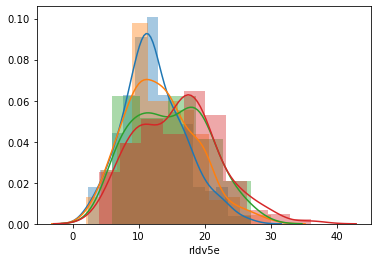

In [40]:
sns.distplot(df[df.source == 'cleveland_minus_corrupted'].rldv5e / 10)
sns.distplot(df[df.source == 'hungarian'].rldv5e)
sns.distplot(df[df.source == 'switzerland'].rldv5e)
sns.distplot(df[df.source == 'long-beach-va'].rldv5e)

There appears to be a 10x scale between the observed values for rldv5e in cleveland as opposed to other sources. We'll remap these and keep the column.

In [41]:
df.rldv5e = df.apply(lambda row: row.rldv5e / 10 if row.source=='cleveland_minus_corrupted' else row.rldv5e, axis=1)

# Classification problem setup (Variables and Target)
Let's define a binary classification column as our target and drop the original CAD column from the predictors. We'll also create a new feature based on the date columns and drop those.

In [48]:
df['target'] = df.cad.map(lambda x: 1 if x > 0 else 0)
date_cols = ['ekg_date', 'angiogram_date']
df['days_between_tests'] = (pd.to_datetime(df.angiogram_date) - pd.to_datetime(df.ekg_date)).map(lambda x: x.days)

X = df.drop(['cad'] + date_cols + ['source'], axis=1).copy()
y = df.target.copy()

In [49]:
cat_cols = X.select_dtypes(include=['object']).columns
numeric = X[[c for c in X.columns if c not in cat_cols]].copy()
X = pd.concat([pd.get_dummies(X[cat_cols]), numeric], axis=1)
X

,sex_F,sex_M,cp_loc_non_substernal,cp_loc_substernal,cp_exertion_no,cp_exertion_yes,cp_rest_relieve_no,cp_rest_relieve_yes,cp_type_atypical_angina,cp_type_no_pain,...,heart_rate_rest,blood_press_s_peak,blood_press_d_peak,blood_press_d_rest,st_dep,rldv5,rldv5e,vessels_colored,target,days_between_tests
0,0,1,0,0,0,0,0,0,0,0,...,60.0,190.0,90.0,85.0,2.3,NaN,17.2,0.0,0,13.0
1,0,1,0,0,0,0,0,0,0,1,...,64.0,160.0,90.0,90.0,1.5,NaN,18.5,3.0,1,-28.0
2,0,1,0,0,0,0,0,0,0,1,...,78.0,140.0,80.0,80.0,2.6,NaN,15.0,2.0,1,1.0
3,0,1,0,0,0,0,0,0,0,0,...,84.0,195.0,68.0,78.0,3.5,NaN,16.7,0.0,0,-9.0
4,1,0,0,0,0,0,0,0,1,0,...,71.0,160.0,74.0,86.0,1.4,NaN,4.0,0.0,0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894,0,1,0,1,0,1,0,1,0,1,...,58.0,215.0,115.0,80.0,1.5,NaN,NaN,NaN,1,1.0
895,0,1,0,1,0,1,0,1,0,1,...,55.0,175.0,85.0,85.0,1.0,NaN,NaN,NaN,1,1.0
896,0,1,1,0,0,1,0,1,0,0,...,64.0,175.0,90.0,85.0,-2.0,NaN,NaN,NaN,1,1.0
897,0,1,0,1,0,1,0,1,0,1,...,58.0,160.0,85.0,80.0,3.0,NaN,NaN,NaN,1,1.0


In [50]:
for name, value in X.corr().target.sort_values().items():
    print('{:<35} {:>8.4f}'.format(name, value))

ex_angina_no                         -0.4429
cp_type_atypical_angina              -0.3965
heart_rate_peak                      -0.3931
sex_F                                -0.3218
cp_exertion_no                       -0.3200
ex_duration                          -0.2924
cp_rest_relieve_no                   -0.2881
thalium_stress_result_normal         -0.2638
nitrate_not_used                     -0.2349
chol                                 -0.2336
heart_rate_rest                      -0.2168
cp_type_non_anginal                  -0.2101
ccblocker_not_used                   -0.1967
betablocker_not_used                 -0.1943
st_slope_peak_up                     -0.1729
ex_protocol_100.0                    -0.1631
ex_protocol_175.0                    -0.1287
diuretic_not_used                    -0.1256
ex_protocol_75.0                     -0.1244
blood_press_s_peak                   -0.1075
ex_protocol_bruce                    -0.0997
ex_hypotension_no                    -0.0939
rest_ecg_n

In [23]:
df.betablocker.value_counts()

not_used    618
used        214
22.0          1
Name: betablocker, dtype: int64